## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical
from sklearn.preprocessing import StandardScaler

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [1, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:400]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [6]:
def plot_generated_scenarios(scenarios, title="Generated Scenarios", num_samples=10):
    """
    Plot a sample of generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      num_samples (int): Number of scenarios to randomly sample and plot.
    """
    # Sample a few scenarios to avoid overcrowding the plot.
    sample_indices = np.random.choice(scenarios.shape[0], size=min(num_samples, scenarios.shape[0]), replace=False)
    sampled_scenarios = scenarios[sample_indices, :]
    
    plt.figure(figsize=(12, 6))
    for scenario in sampled_scenarios:
        plt.plot(scenario, alpha=0.7)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Returns")
    plt.grid(True)
    plt.show()

def plot_generated_distribution(scenarios, title="Distribution of Cumulative Returns", bins=500):
    """
    Plot the distribution of cumulative returns computed from the generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      bins (int): Number of bins for the histogram.
    """
    # Compute cumulative returns for each scenario.
    cumulative_returns = np.array([np.prod(1 + scenario) - 1 for scenario in scenarios])
    
    plt.figure(figsize=(10, 6))
    plt.hist(cumulative_returns, bins=bins, density=True, alpha=0.6, color='b')
    plt.title(title)
    plt.xlabel("Cumulative Return")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


In [ ]:
from OliviaGAN import OliviaGAN
from MarketGAN import MarketGAN
from FashionGAN import FashionGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = FashionGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

Training GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

Training GAN for PE...
[Epoch 0/300] [Batch 0/25] [D loss: 1.5828] [G loss: 41.4178] [Tail penalty: 0.2933] [Structure penalty: 0.8434]
[Epoch 0/300] [Batch 10/25] [D loss: 0.5109] [G loss: 30.5672] [Tail penalty: 0.1464] [Structure penalty: 0.7517]
[Epoch 0/300] [Batch 20/25] [D loss: 0.5426] [G loss: 26.4559] [Tail penalty: 0.0525] [Structure penalty: 0.7867]
[Epoch 1/300] [Batch 0/25] [D loss: 0.7047] [G loss: 22.1533] [Tail penalty: 0.0125] [Structure penalty: 0.7164]
[Epoch 1/300] [Batch 10/25] [D loss: 0.6489] [G loss: 21.4919] [Tail penalty: 0.0020] [Structure penalty: 0.7128]
[Epoch 1/300] [Batch 20/25] [D loss: 0.5195] [G loss: 22.0737] [Tail penalty: 0.0003] [Structure penalty: 0.7367]
[Epoch 2/300] [Batch 0/25] [D loss: 0.6085] [G loss: 20.5114] [Tail penalty: 0.0000] [Structure penalty: 0.6859]
[Epoch 2/300] [Batch 10/25] [D loss: 0.5364] [G loss: 19.8396] [Tail penalty: 0.0000] [Structure penalty: 0.6626]
[Epoch 2/300] [Batch 20/25] [D loss: 0.5034] [G loss: 19.8696] [Tail

Training GANs:  50%|█████     | 1/2 [08:01<08:01, 481.20s/asset]

Finished training GAN for PE.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Finished generating scenarios for PE.

PE: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for EONIA...
[Epoch 0/300] [Batch 0/25] [D loss: 27.5704] [G loss: 570.0630] [Tail penalty: 1.9175] [Structure penalty: 15.4948]
[Epoch 0/300] [Batch 10/25] [D loss: 9.1699] [G loss: 960.6257] [Tail penalty: 1.5283] [Structure penalty: 29.2229]
[Epoch 0/300] [Batch 20/25] [D loss: 3.1772] [G loss: 766.3181] [Tail penalty: 1.2121] [Structure penalty: 23.3263]
[Epoch 1/300] [Batch 0/25] [D loss: 5.8964] [G loss: 426.9205] [Tail penalty: 0.9833] [Structure penalty: 12.4322]
[Epoch 1/300] [Batch 10/25] [D loss: 3.7522] [G loss: 210.8103] [Tail penalty: 0.7911] [Structure penalty: 5.5818]
[Epoch 1/300] [Batch 20/25] [D loss: 3.0503] [G loss: 93.8731] [Tail penalty: 0.6469] [Structure penalty: 1.9480]
[Epoch 2/300] [Batch 0/25] [D loss: 3.4872] [G loss

In [ ]:
for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    gan = gan_dict[asset_name]
    foundNAN = False
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        print("date", test_day)

        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, save=False, num_scenarios=10000)

        # plot_generated_distribution(scenarios=scenarios)
        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break

        print(f"{asset_name}: Generated new distribution on {test_day}.")

        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")
    
    if foundNAN: break

Updating GANs:   0%|          | 0/2 [00:00<?, ?asset/s]

date 2020-01-02 00:00:00
PE: Generated new distribution on 2020-01-02 00:00:00.
PE: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
PE: Generated new distribution on 2020-01-03 00:00:00.
PE: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
PE: Generated new distribution on 2020-01-06 00:00:00.
PE: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
PE: Generated new distribution on 2020-01-07 00:00:00.
PE: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
PE: Generated new distribution on 2020-01-08 00:00:00.
PE: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
PE: Generated new distribution on 2020-01-09 00:00:00.
PE: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
PE: Generated new distribution on 2020-01-10 00:00:00.
PE: Stored generated scenarios for 2020-01-10 00:00:00.
date 2020-01-13 00:00:00
PE: Generated new distr

Updating GANs:  50%|█████     | 1/2 [08:54<08:54, 534.07s/asset]

PE: Generated new distribution on 2021-07-27 00:00:00.
PE: Stored generated scenarios for 2021-07-27 00:00:00.
date 2020-01-02 00:00:00
EONIA: Generated new distribution on 2020-01-02 00:00:00.
EONIA: Stored generated scenarios for 2020-01-02 00:00:00.
date 2020-01-03 00:00:00
EONIA: Generated new distribution on 2020-01-03 00:00:00.
EONIA: Stored generated scenarios for 2020-01-03 00:00:00.
date 2020-01-06 00:00:00
EONIA: Generated new distribution on 2020-01-06 00:00:00.
EONIA: Stored generated scenarios for 2020-01-06 00:00:00.
date 2020-01-07 00:00:00
EONIA: Generated new distribution on 2020-01-07 00:00:00.
EONIA: Stored generated scenarios for 2020-01-07 00:00:00.
date 2020-01-08 00:00:00
EONIA: Generated new distribution on 2020-01-08 00:00:00.
EONIA: Stored generated scenarios for 2020-01-08 00:00:00.
date 2020-01-09 00:00:00
EONIA: Generated new distribution on 2020-01-09 00:00:00.
EONIA: Stored generated scenarios for 2020-01-09 00:00:00.
date 2020-01-10 00:00:00
EONIA: Gener

Updating GANs: 100%|██████████| 2/2 [17:37<00:00, 528.66s/asset]

EONIA: Generated new distribution on 2021-07-27 00:00:00.
EONIA: Stored generated scenarios for 2021-07-27 00:00:00.


In [ ]:
returns_df.tail()

,PE,EONIA
Date,,
2019-12-23,-0.006826,-0.000045
2019-12-24,0.001789,-0.000015
2019-12-27,0.003310,-0.000015
2019-12-30,-0.005184,-0.000045
2019-12-31,-0.000405,-0.000015


In [ ]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

## We need to get rolling Delta BOF

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

,PE,EONIA
Date,,
2021-07-21,0.020856,-0.000016
2021-07-22,0.022455,-0.000016
2021-07-23,0.012661,-0.000016
2021-07-26,0.003743,-0.000047
2021-07-27,-0.003492,-0.000016


In [ ]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2021-07-27 00:00:00


,PE,EONIA
Date,,
2019-01-03,-0.016792,-0.00001
2019-01-04,0.029982,-0.00001
2019-01-07,0.016009,-0.00003
2019-01-08,0.012384,-0.00001
2019-01-09,0.003621,-0.00001


In [ ]:
historical_df.tail()

,PE,EONIA
Date,,
2021-07-21,0.020856,-0.000016
2021-07-22,0.022455,-0.000016
2021-07-23,0.012661,-0.000016
2021-07-26,0.003743,-0.000047
2021-07-27,-0.003492,-0.000016


In [ ]:
entire_df.tail()

,PE,EONIA
Date,,
2021-07-21,0.020856,-0.000016
2021-07-22,0.022455,-0.000016
2021-07-23,0.012661,-0.000016
2021-07-26,0.003743,-0.000047
2021-07-27,-0.003492,-0.000016


# CASE 1

- We first calculate realized delta BOF for a given window

In [ ]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

portfolio_returns = (historical_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

daily_delta_bof = bof.diff().fillna(0)


rolling_delta_bof = daily_delta_bof.rolling(window=252).sum()


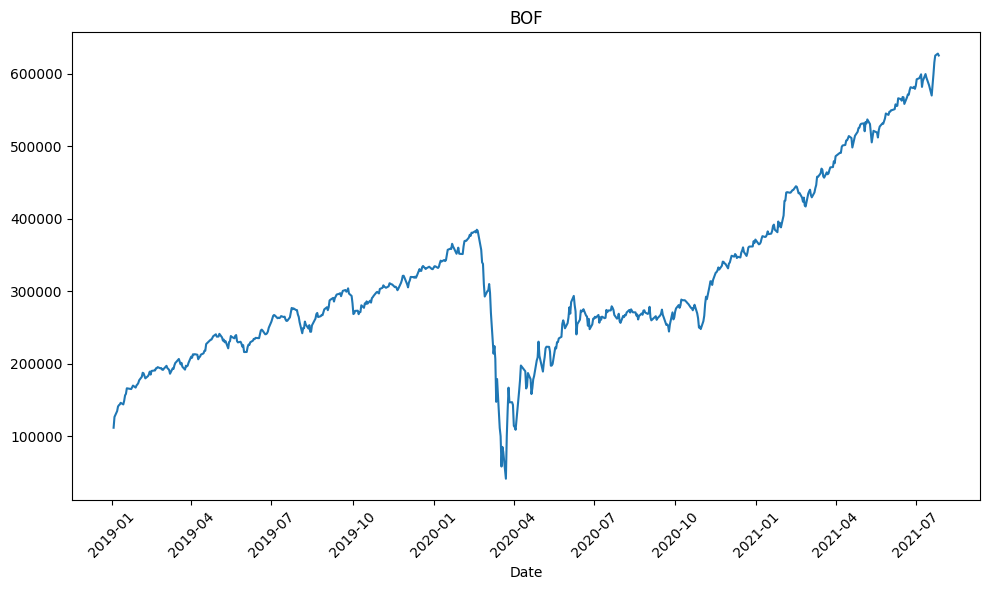

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bof.index, bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("BOF")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

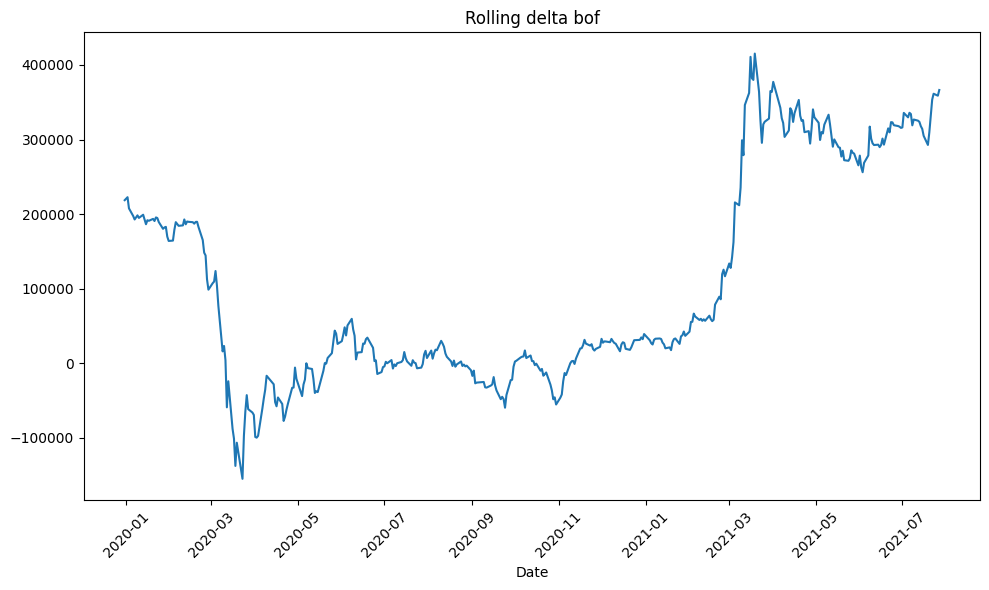

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("Rolling delta bof")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Case 2

Same, assuming constant BOF0

In [ ]:
bof.loc["2019-12-31"]

np.float64(330303.87111724855)

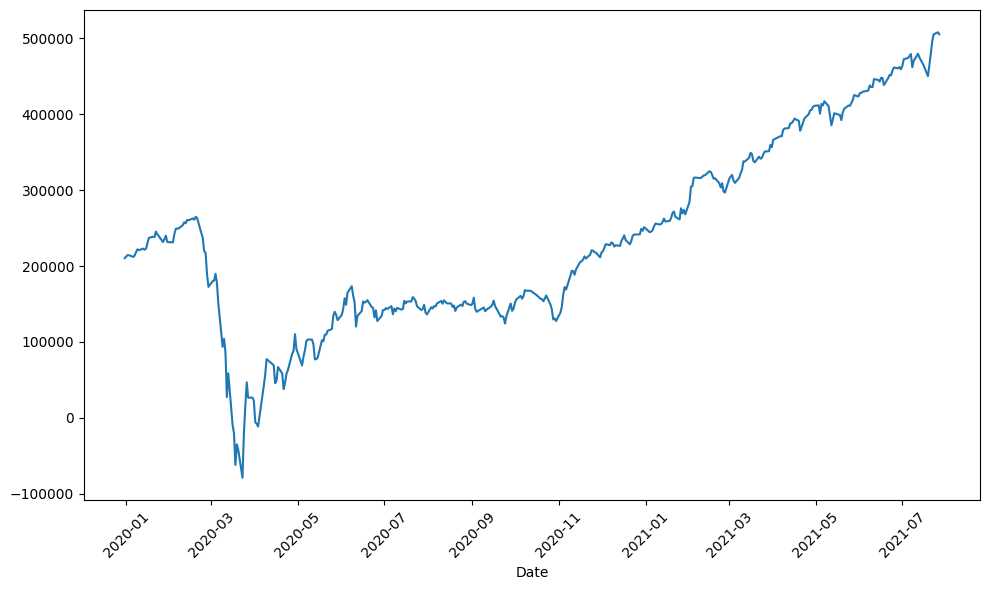

In [ ]:
bof_case_ii = bof.loc["2019-12-31":]

delta_bof_case_ii = bof_case_ii - bof_0

plt.figure(figsize=(10, 6))
plt.plot(delta_bof_case_ii.index, delta_bof_case_ii.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

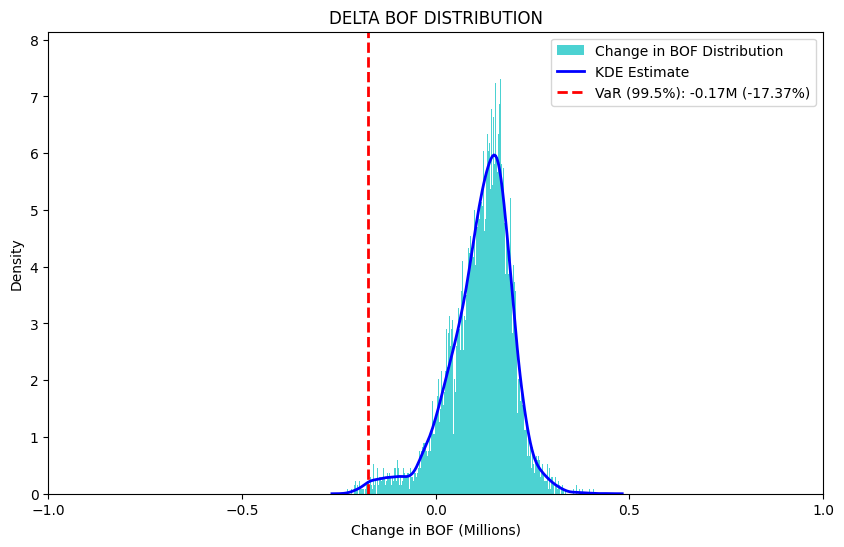

Date 2019-12-31 00:00:00: SCR = -173671.59668437956
Date 2020-01-02 00:00:00: SCR = 43544.681228666304
Date 2020-01-03 00:00:00: SCR = 34716.16049748424
Date 2020-01-06 00:00:00: SCR = 36829.105765438086
Date 2020-01-07 00:00:00: SCR = 40329.342059412
Date 2020-01-08 00:00:00: SCR = 40021.93737053872
Date 2020-01-09 00:00:00: SCR = 43643.28477128029
Date 2020-01-10 00:00:00: SCR = 42580.453921298984
Date 2020-01-13 00:00:00: SCR = 40578.8455894661
Date 2020-01-14 00:00:00: SCR = 45089.54919685366
Date 2020-01-15 00:00:00: SCR = 47353.85598956108
Date 2020-01-16 00:00:00: SCR = 49782.26976696015
Date 2020-01-17 00:00:00: SCR = 47921.73889115335
Date 2020-01-20 00:00:00: SCR = 48070.095051832235
Date 2020-01-21 00:00:00: SCR = 49815.23959441186
Date 2020-01-22 00:00:00: SCR = 46272.83159132004
Date 2020-01-23 00:00:00: SCR = 43174.41477758409
Date 2020-01-24 00:00:00: SCR = 44841.018754329685
Date 2020-01-27 00:00:00: SCR = 43394.01717144967


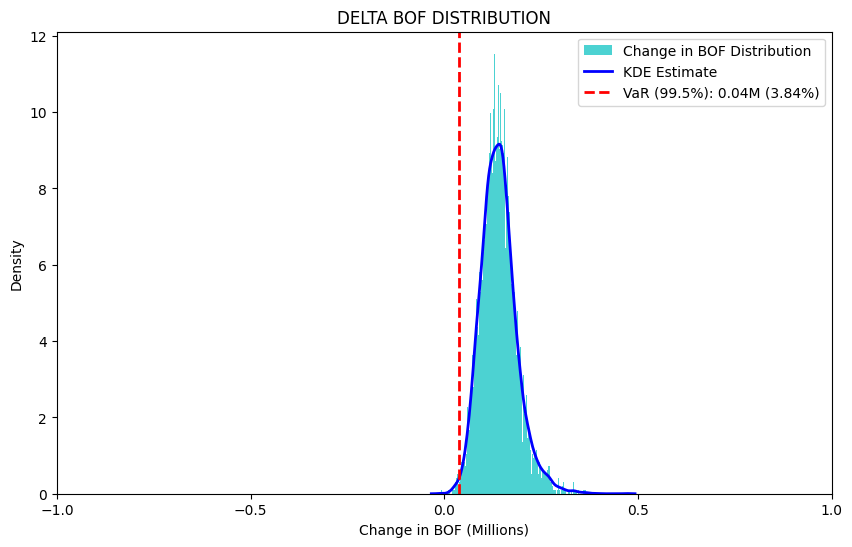

Date 2020-01-28 00:00:00: SCR = 38429.32346380236
Date 2020-01-29 00:00:00: SCR = 51175.72954519272
Date 2020-01-30 00:00:00: SCR = 52846.252553377155
Date 2020-01-31 00:00:00: SCR = 52236.08052165032
Date 2020-02-03 00:00:00: SCR = 44958.59936067582
Date 2020-02-04 00:00:00: SCR = 43824.62808608056
Date 2020-02-05 00:00:00: SCR = 43129.956446571356
Date 2020-02-06 00:00:00: SCR = 41354.52715198519
Date 2020-02-07 00:00:00: SCR = 42290.242913618094
Date 2020-02-10 00:00:00: SCR = 41148.480342655195
Date 2020-02-11 00:00:00: SCR = 48115.1305762577
Date 2020-02-12 00:00:00: SCR = 46068.44376478196
Date 2020-02-13 00:00:00: SCR = 47209.02506461145
Date 2020-02-14 00:00:00: SCR = 46715.39013653756
Date 2020-02-17 00:00:00: SCR = 43495.28706099512
Date 2020-02-18 00:00:00: SCR = 46483.438163595245
Date 2020-02-19 00:00:00: SCR = 45383.25587544441
Date 2020-02-20 00:00:00: SCR = 49049.40052621842
Date 2020-02-21 00:00:00: SCR = 46818.866304636
Date 2020-02-24 00:00:00: SCR = 43352.0364554977

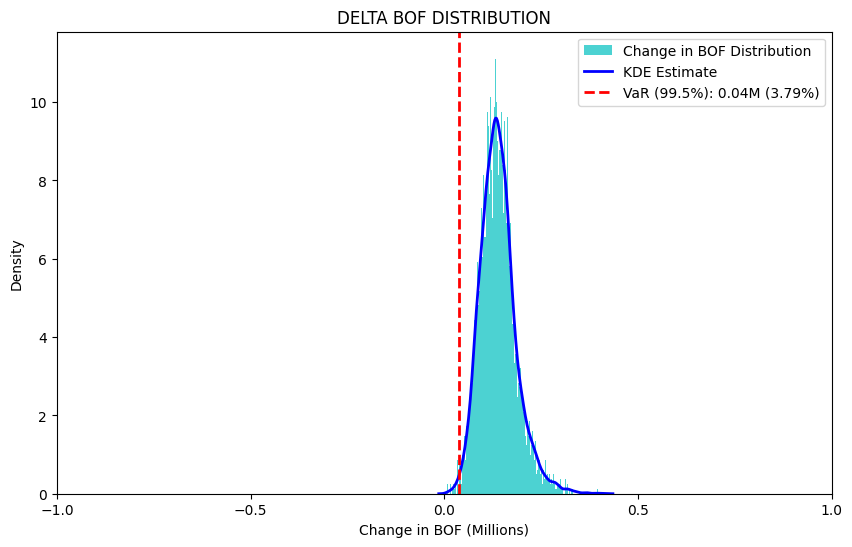

Date 2020-02-25 00:00:00: SCR = 37899.376235132244
Date 2020-02-26 00:00:00: SCR = 30549.479141254425
Date 2020-02-27 00:00:00: SCR = 36651.07367094994
Date 2020-02-28 00:00:00: SCR = 33997.027883014685
Date 2020-03-02 00:00:00: SCR = 32624.660791816717
Date 2020-03-03 00:00:00: SCR = 36889.333450527214
Date 2020-03-04 00:00:00: SCR = 37622.7101203537
Date 2020-03-05 00:00:00: SCR = 38262.825059938434
Date 2020-03-06 00:00:00: SCR = 36783.82803934097
Date 2020-03-09 00:00:00: SCR = 39756.37476891518
Date 2020-03-10 00:00:00: SCR = 41497.906791143425
Date 2020-03-11 00:00:00: SCR = 36732.79364566804
Date 2020-03-12 00:00:00: SCR = 34335.378684005766
Date 2020-03-13 00:00:00: SCR = 39803.465316982285
Date 2020-03-16 00:00:00: SCR = 32010.85735748291
Date 2020-03-17 00:00:00: SCR = 27672.890305032743
Date 2020-03-18 00:00:00: SCR = 28100.80615316392
Date 2020-03-19 00:00:00: SCR = 31862.906875696182
Date 2020-03-20 00:00:00: SCR = 31595.383738183984
Date 2020-03-23 00:00:00: SCR = 30784.4

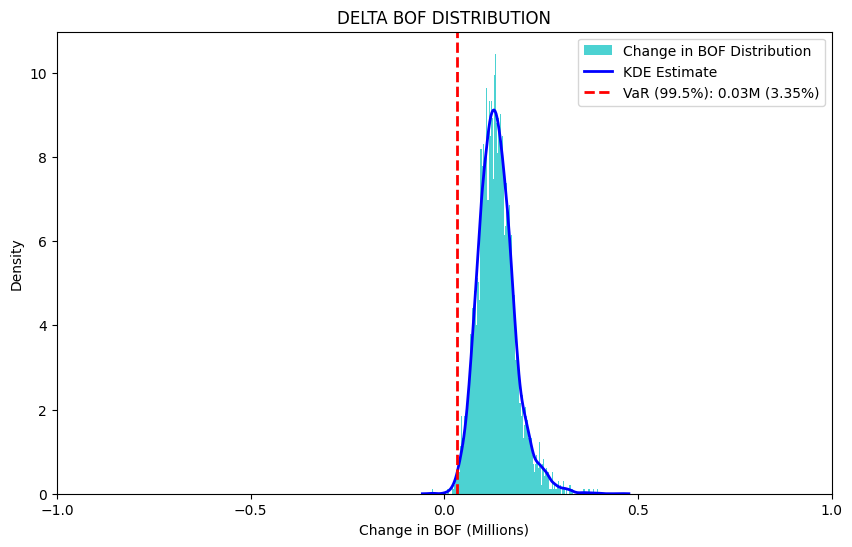

Date 2020-03-24 00:00:00: SCR = 33488.17216161728
Date 2020-03-25 00:00:00: SCR = 34067.28391074181
Date 2020-03-26 00:00:00: SCR = 33123.902139854436
Date 2020-03-27 00:00:00: SCR = 30850.910699119577
Date 2020-03-30 00:00:00: SCR = 24599.327675399818
Date 2020-03-31 00:00:00: SCR = 32245.50766761781
Date 2020-04-01 00:00:00: SCR = 26810.578303308495
Date 2020-04-02 00:00:00: SCR = 27475.45088259697
Date 2020-04-03 00:00:00: SCR = 28011.109572849287
Date 2020-04-06 00:00:00: SCR = 33711.124351263075
Date 2020-04-07 00:00:00: SCR = 32998.128314371126
Date 2020-04-08 00:00:00: SCR = 32062.041679077156
Date 2020-04-09 00:00:00: SCR = 29634.296064357764
Date 2020-04-14 00:00:00: SCR = 34308.33076182366
Date 2020-04-15 00:00:00: SCR = 31962.64428353311
Date 2020-04-16 00:00:00: SCR = 35564.8122736168
Date 2020-04-17 00:00:00: SCR = 37930.007770528806
Date 2020-04-20 00:00:00: SCR = 29860.96465607644
Date 2020-04-21 00:00:00: SCR = 30566.706707115176
Date 2020-04-22 00:00:00: SCR = 32730.82

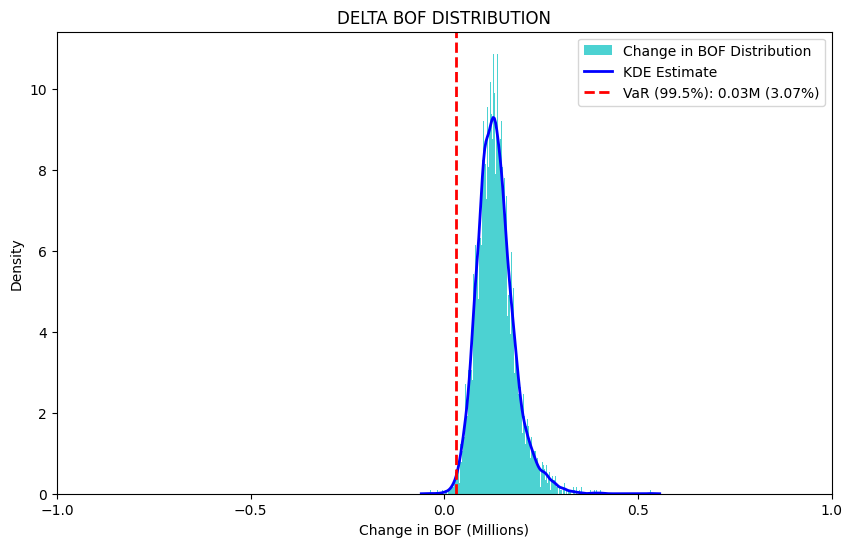

Date 2020-04-23 00:00:00: SCR = 30662.257423219697
Date 2020-04-24 00:00:00: SCR = 30025.54205650331
Date 2020-04-27 00:00:00: SCR = 24588.01661019326
Date 2020-04-28 00:00:00: SCR = 24554.472349758147
Date 2020-04-29 00:00:00: SCR = 27624.205119628914
Date 2020-04-30 00:00:00: SCR = 28042.776933584217
Date 2020-05-04 00:00:00: SCR = 34402.64209691049
Date 2020-05-05 00:00:00: SCR = 31224.300733432807
Date 2020-05-06 00:00:00: SCR = 31304.632118825924
Date 2020-05-07 00:00:00: SCR = 37652.06526534082
Date 2020-05-08 00:00:00: SCR = 41288.138489503865
Date 2020-05-11 00:00:00: SCR = 39233.98872132302
Date 2020-05-12 00:00:00: SCR = 40359.609879074116
Date 2020-05-13 00:00:00: SCR = 42550.02085123063
Date 2020-05-14 00:00:00: SCR = 46644.04008060456
Date 2020-05-15 00:00:00: SCR = 43010.90862454417
Date 2020-05-18 00:00:00: SCR = 43156.76892390253
Date 2020-05-19 00:00:00: SCR = 42074.85914647105
Date 2020-05-20 00:00:00: SCR = 46655.16076429367
Date 2020-05-21 00:00:00: SCR = 42579.3510

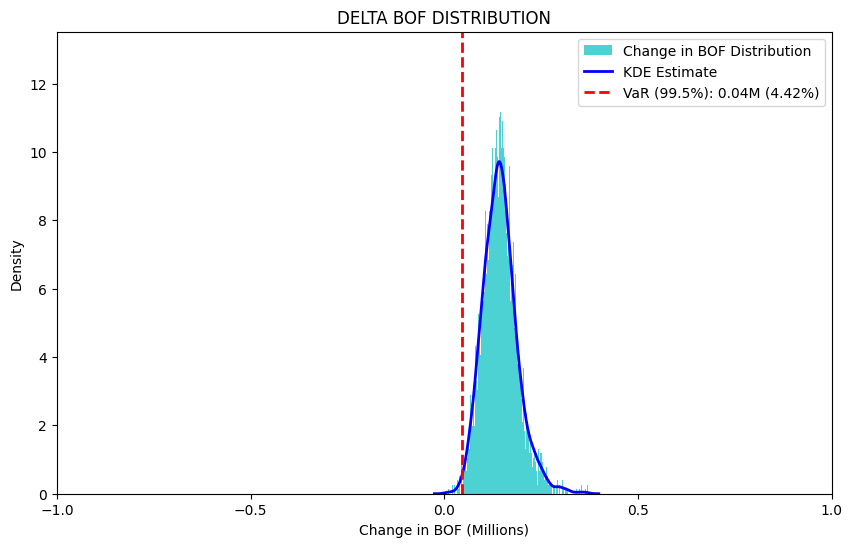

Date 2020-05-22 00:00:00: SCR = 44173.83789081574
Date 2020-05-25 00:00:00: SCR = 47227.69231014252
Date 2020-05-26 00:00:00: SCR = 43558.62525141718
Date 2020-05-27 00:00:00: SCR = 52458.99758700372
Date 2020-05-28 00:00:00: SCR = 51147.996586523055
Date 2020-05-29 00:00:00: SCR = 54353.99644077302
Date 2020-06-01 00:00:00: SCR = 53351.586860132236
Date 2020-06-02 00:00:00: SCR = 53989.051626148226
Date 2020-06-03 00:00:00: SCR = 55178.89577438355
Date 2020-06-04 00:00:00: SCR = 53383.031071290985
Date 2020-06-05 00:00:00: SCR = 53790.078209209445
Date 2020-06-08 00:00:00: SCR = 51542.5425718117
Date 2020-06-09 00:00:00: SCR = 49661.19467904092
Date 2020-06-10 00:00:00: SCR = 48938.39329575539
Date 2020-06-11 00:00:00: SCR = 48604.22179096222
Date 2020-06-12 00:00:00: SCR = 51652.837624835985
Date 2020-06-15 00:00:00: SCR = 53750.939035282136
Date 2020-06-16 00:00:00: SCR = 53938.67421194077
Date 2020-06-17 00:00:00: SCR = 46172.741334486025
Date 2020-06-18 00:00:00: SCR = 48654.93537

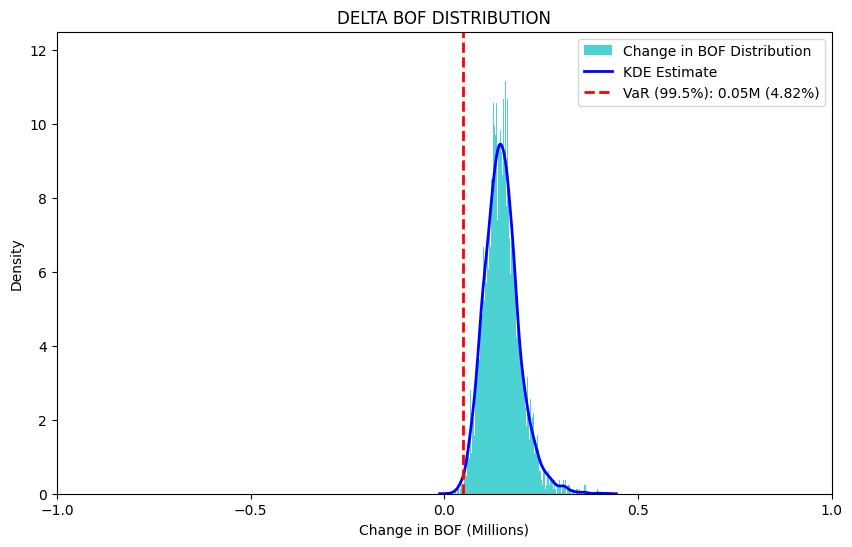

Date 2020-06-19 00:00:00: SCR = 48198.13188307764
Date 2020-06-22 00:00:00: SCR = 47158.283883724216
Date 2020-06-23 00:00:00: SCR = 45699.10858487131
Date 2020-06-24 00:00:00: SCR = 47699.67947999002
Date 2020-06-25 00:00:00: SCR = 49605.15633642198
Date 2020-06-26 00:00:00: SCR = 47719.290725927356
Date 2020-06-29 00:00:00: SCR = 51363.03035215378
Date 2020-06-30 00:00:00: SCR = 47230.44343067171
Date 2020-07-01 00:00:00: SCR = 49341.288578977605
Date 2020-07-02 00:00:00: SCR = 51753.393080511094
Date 2020-07-03 00:00:00: SCR = 46289.86520171167
Date 2020-07-06 00:00:00: SCR = 46736.643178949365
Date 2020-07-07 00:00:00: SCR = 50428.0851117611
Date 2020-07-08 00:00:00: SCR = 49432.62647183419
Date 2020-07-09 00:00:00: SCR = 47885.0075202656
Date 2020-07-10 00:00:00: SCR = 48022.904237957
Date 2020-07-13 00:00:00: SCR = 46168.78628128052
Date 2020-07-14 00:00:00: SCR = 48076.80000555993
Date 2020-07-15 00:00:00: SCR = 47628.03722819329
Date 2020-07-16 00:00:00: SCR = 50343.73563049321

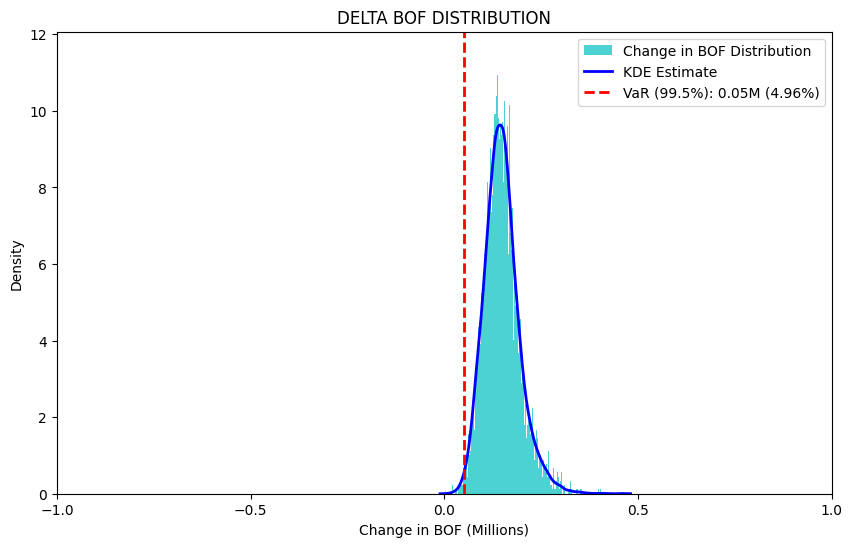

Date 2020-07-17 00:00:00: SCR = 49583.0339878273
Date 2020-07-20 00:00:00: SCR = 48510.797574024204
Date 2020-07-21 00:00:00: SCR = 51915.59359683991
Date 2020-07-22 00:00:00: SCR = 48062.21888144494
Date 2020-07-23 00:00:00: SCR = 49562.43903909685
Date 2020-07-24 00:00:00: SCR = 53099.04168018342
Date 2020-07-27 00:00:00: SCR = 52246.096664543176
Date 2020-07-28 00:00:00: SCR = 54161.00082994461
Date 2020-07-29 00:00:00: SCR = 55794.0980943203
Date 2020-07-30 00:00:00: SCR = 56869.84169097901
Date 2020-07-31 00:00:00: SCR = 58328.62423470498
Date 2020-08-03 00:00:00: SCR = 57708.256830577855
Date 2020-08-04 00:00:00: SCR = 59473.59072616577
Date 2020-08-05 00:00:00: SCR = 65881.08174078942
Date 2020-08-06 00:00:00: SCR = 62978.227327699664
Date 2020-08-07 00:00:00: SCR = 63479.76153759003
Date 2020-08-10 00:00:00: SCR = 65203.609209795
Date 2020-08-11 00:00:00: SCR = 68497.97890938759
Date 2020-08-12 00:00:00: SCR = 69253.38632729532
Date 2020-08-13 00:00:00: SCR = 67828.60359562874


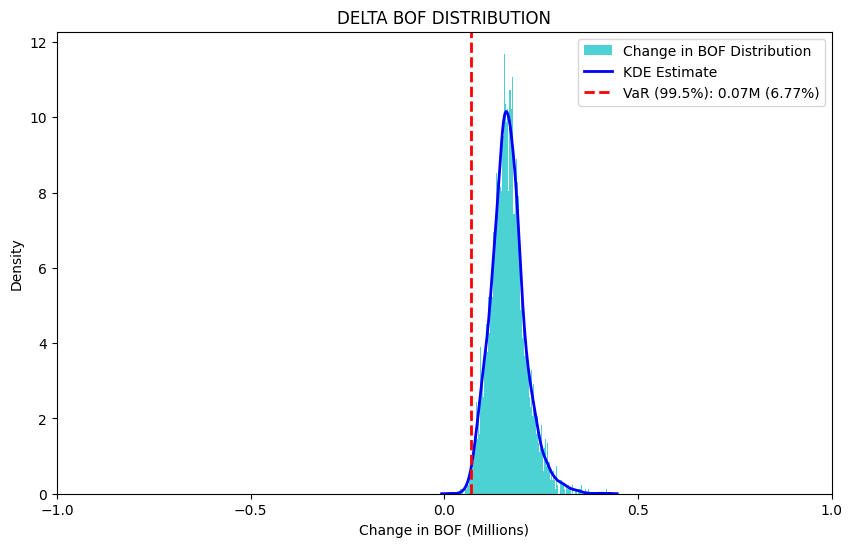

Date 2020-08-14 00:00:00: SCR = 67700.27980945587
Date 2020-08-17 00:00:00: SCR = 71358.15217199326
Date 2020-08-18 00:00:00: SCR = 70898.92303839684
Date 2020-08-19 00:00:00: SCR = 70055.64668097498
Date 2020-08-20 00:00:00: SCR = 71967.97666831971
Date 2020-08-21 00:00:00: SCR = 69558.08671682359
Date 2020-08-24 00:00:00: SCR = 68956.67940598489
Date 2020-08-25 00:00:00: SCR = 73067.09449128152
Date 2020-08-26 00:00:00: SCR = 71131.78947619439
Date 2020-08-27 00:00:00: SCR = 71739.89165885925
Date 2020-08-28 00:00:00: SCR = 68406.17431995392
Date 2020-08-31 00:00:00: SCR = 68190.15146837237
Date 2020-09-01 00:00:00: SCR = 69520.51774785997
Date 2020-09-02 00:00:00: SCR = 70024.31417785646
Date 2020-09-03 00:00:00: SCR = 69849.72019661903
Date 2020-09-04 00:00:00: SCR = 71066.14996891975
Date 2020-09-09 00:00:00: SCR = 70109.2245626545
Date 2020-09-10 00:00:00: SCR = 70462.39596933365
Date 2020-09-11 00:00:00: SCR = 71933.33617360117
Date 2020-09-14 00:00:00: SCR = 71379.61978709222


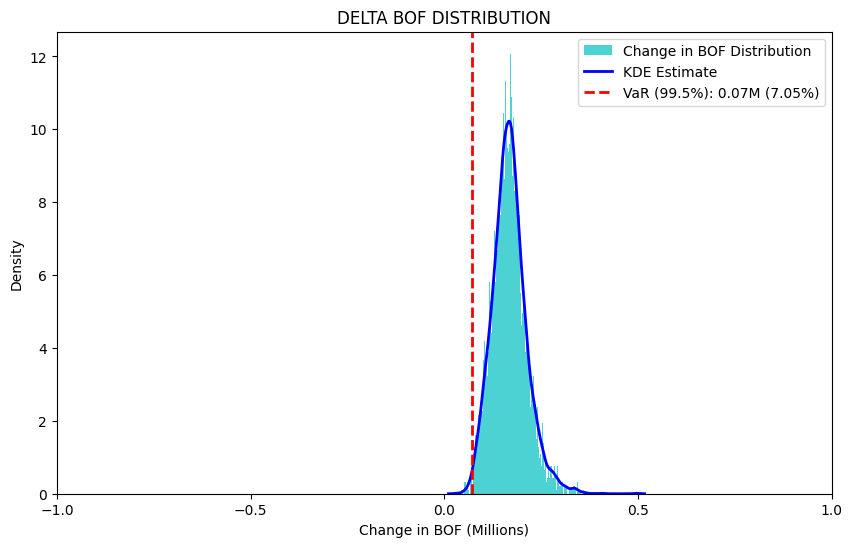

Date 2020-09-15 00:00:00: SCR = 70486.21795103073
Date 2020-09-16 00:00:00: SCR = 72049.32431969643
Date 2020-09-17 00:00:00: SCR = 70596.94943840028
Date 2020-09-18 00:00:00: SCR = 70144.35864274025
Date 2020-09-21 00:00:00: SCR = 71596.00641213417
Date 2020-09-22 00:00:00: SCR = 72054.47216471673
Date 2020-09-23 00:00:00: SCR = 72699.61378320695
Date 2020-09-24 00:00:00: SCR = 70168.94044571878
Date 2020-09-25 00:00:00: SCR = 73088.38079455377
Date 2020-09-28 00:00:00: SCR = 72703.40898491861
Date 2020-09-29 00:00:00: SCR = 73202.99873163224
Date 2020-09-30 00:00:00: SCR = 72403.62438668251
Date 2020-10-01 00:00:00: SCR = 73983.56135695458
Date 2020-10-02 00:00:00: SCR = 71530.36559690475
Date 2020-10-05 00:00:00: SCR = 71280.13837491989
Date 2020-10-06 00:00:00: SCR = 75455.71538024902
Date 2020-10-07 00:00:00: SCR = 74907.6138956547
Date 2020-10-08 00:00:00: SCR = 75817.59862773896
Date 2020-10-09 00:00:00: SCR = 76387.50428767205
Date 2020-10-12 00:00:00: SCR = 76092.90339885712


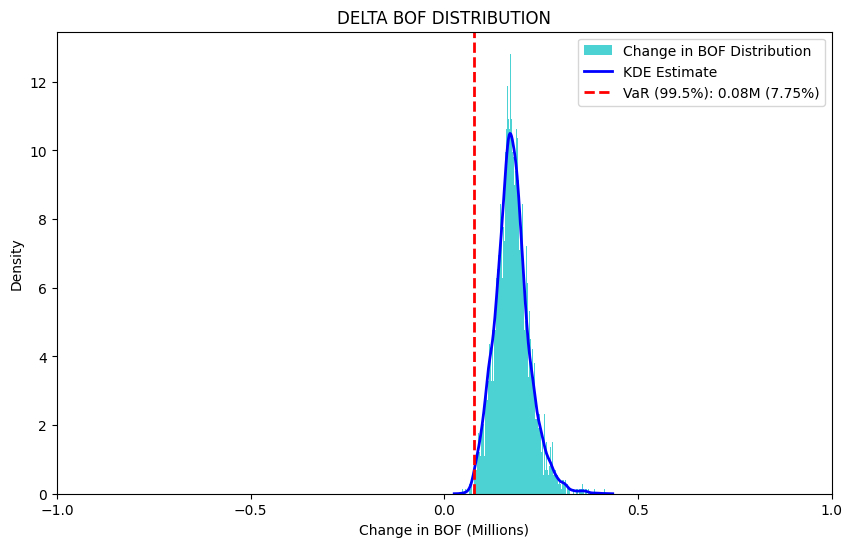

Date 2020-10-13 00:00:00: SCR = 77506.66819522857


In [ ]:
asset_names = list(returns_df.columns)

from utilities.bof_var_plot import plot_bof_var

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

i = 0
for date in all_dates[:200]:
    i += 1
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        if np.isnan(asset_cum).any() or np.isinf(asset_cum).any():
            print(f"Warning: NaN or Inf encountered in cumulative returns for asset {asset} on date {date}.")
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.

    bof_0_case_i = bof.iloc[bof.index.get_loc(date) - 252]

    portfolio = SimpleGANPortfolio(gan_samples, weights, bof0_casei=bof_0_case_i)
    bof_change, scr = portfolio.calculate_distribution_and_scr(case=2)

    if i % 20 == 0 or i == 1:
        plot_bof_var(bof_change,scr,"DELTA BOF DISTRIBUTION")
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


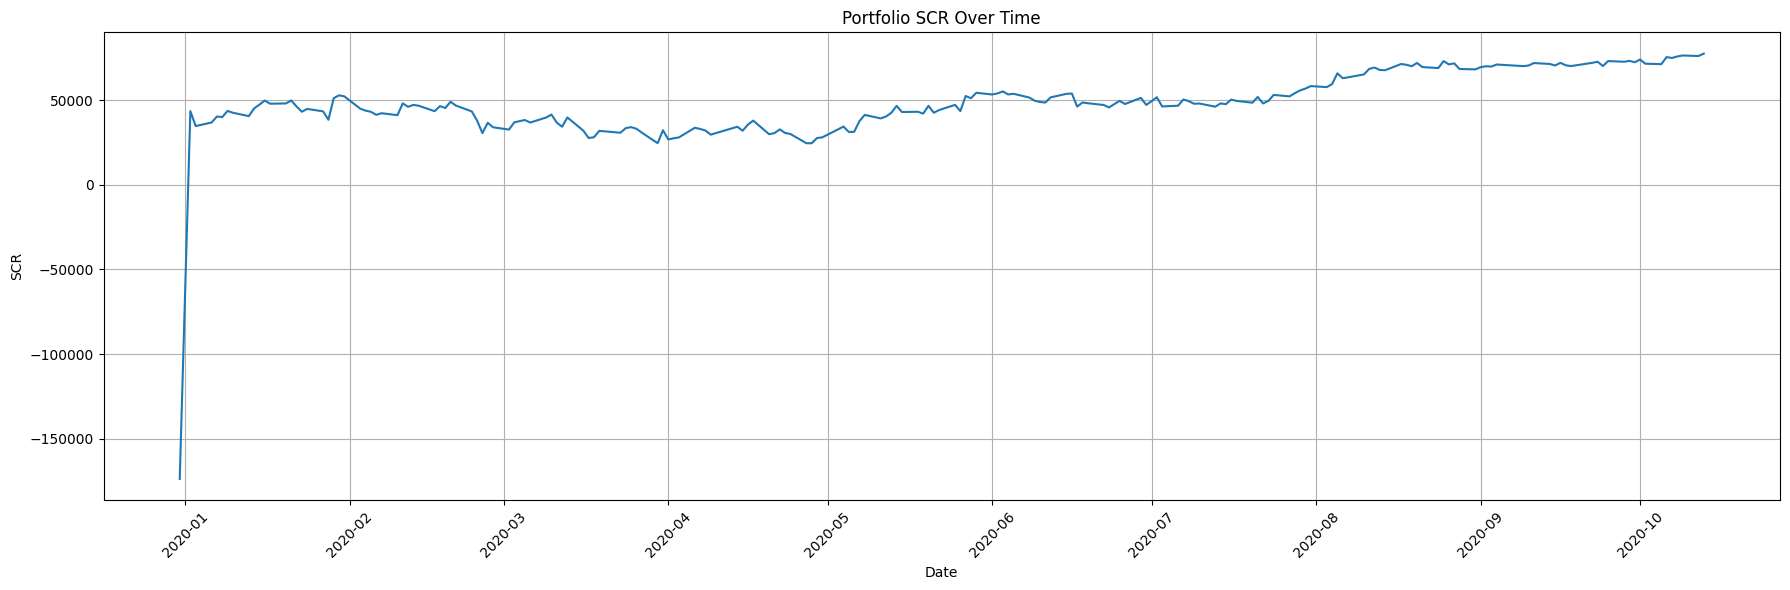

In [ ]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Try out exponential weighting.

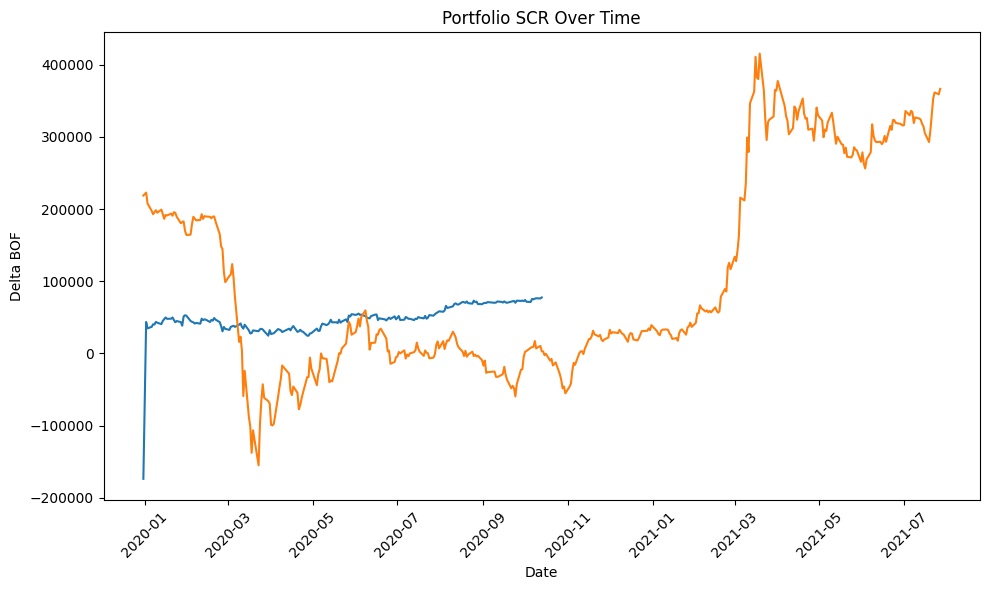

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Delta BOF")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Scaled = False


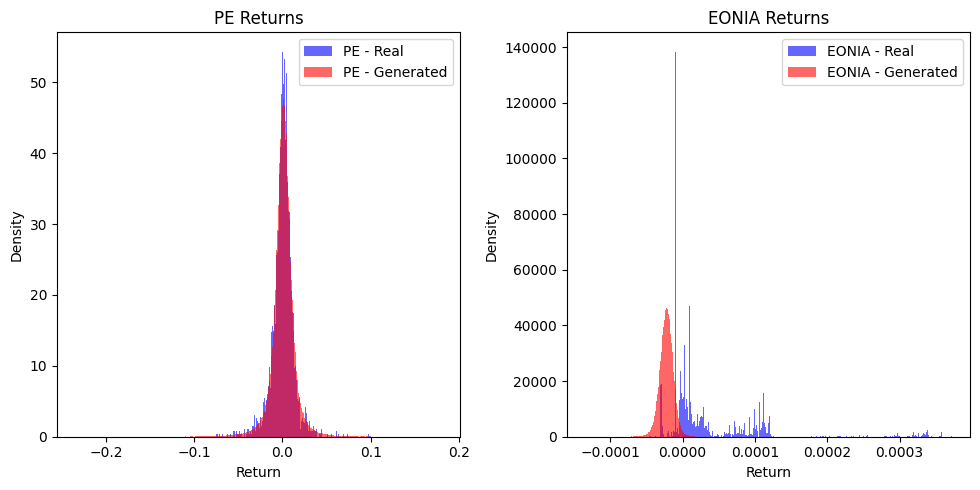


📊 Return Statistics Summary:
            Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
        PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
   PE - Generated  0.000852 0.014277 -0.776578 16.599699  -0.057362
     EONIA - Real  0.000032 0.000069  2.682698  8.158064  -0.000031
EONIA - Generated -0.000022 0.000010 -0.382657  2.586308  -0.000053



═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.000147
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.236619
✅ Generated samples are reasonably diverse


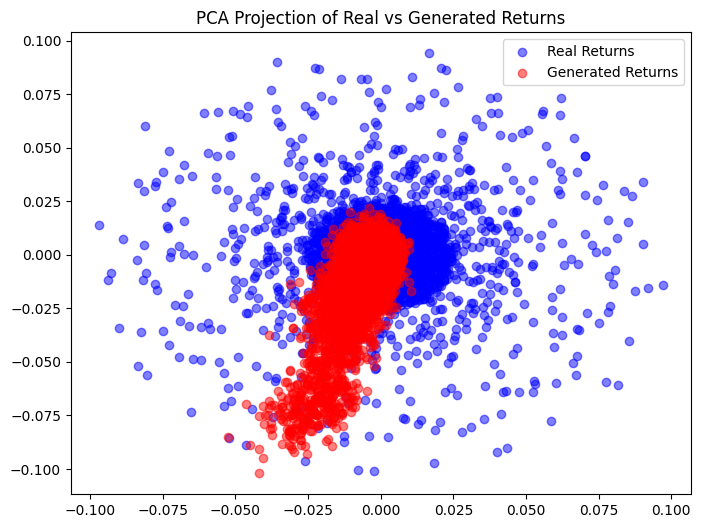

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt


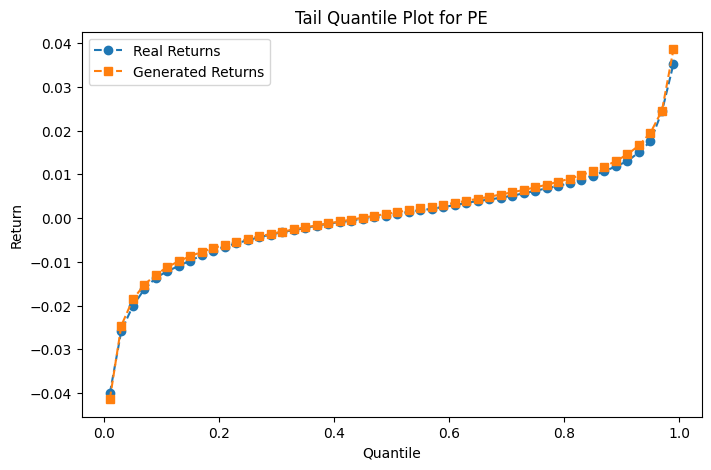


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt

📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 11.267795
Mean Distance: 0.005435
Median Distance: 0.000282
Standard Deviation: 0.118998


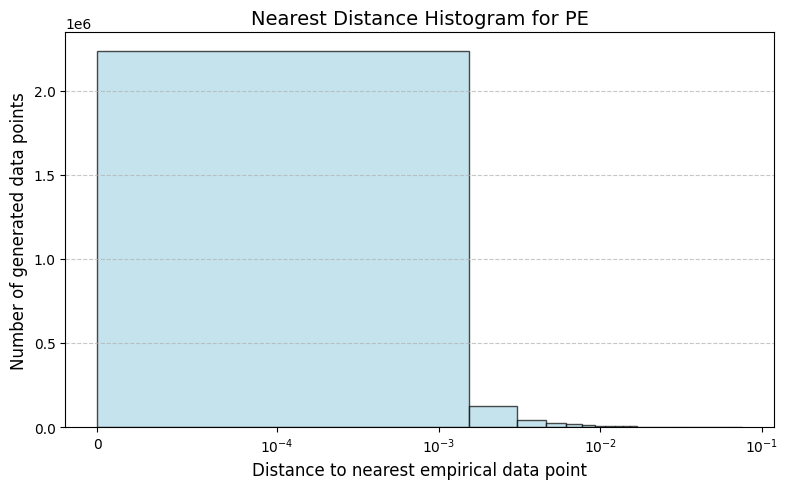


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
📊 Wasserstein Distance for PE: 0.000911


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
⚠️ Warning: Possible Mode Collapse - Low Variance in Generated Data
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.000204
⚠️ Warning: Potential Mode Collapse - Samples are too similar


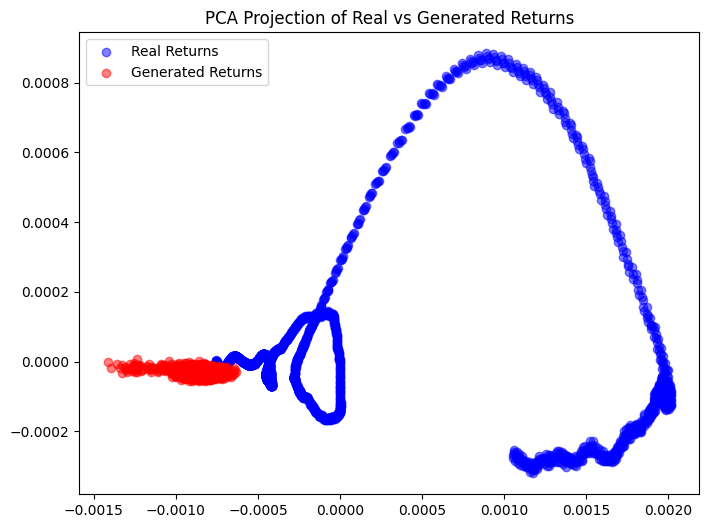


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_CGAN_output_test\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000054



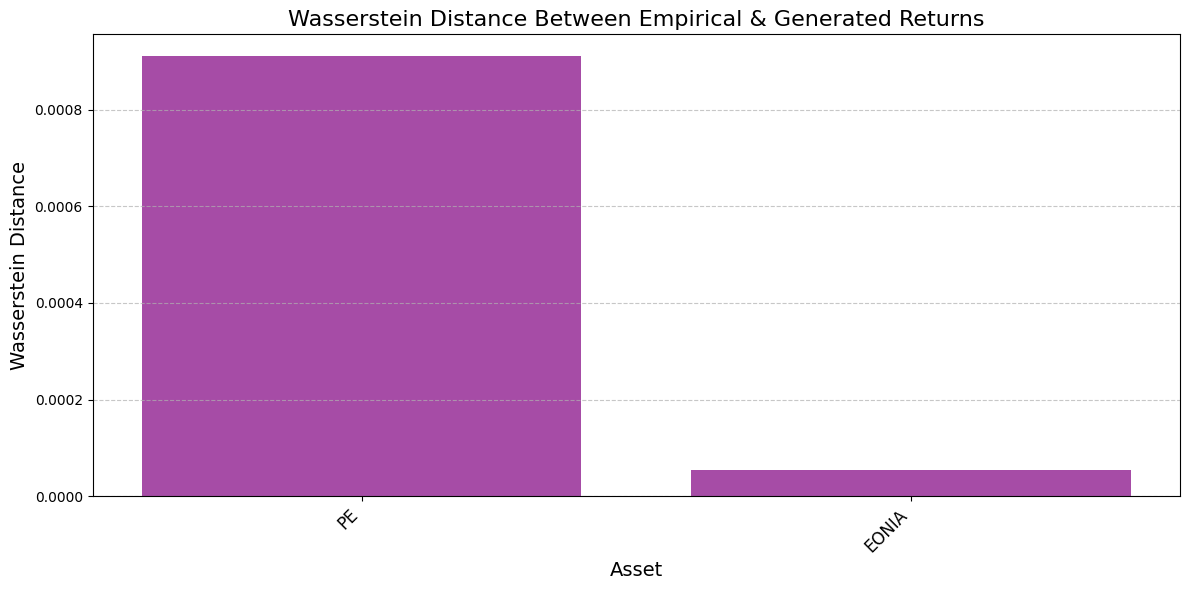

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [ ]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_PE_q0.pt'